## Udemy CodeChallenge: Manipulating Regression Slopes

### **Pasos**

- ### 1) Crear una función en Python que construya y entreno el modelo, y dé como output las predicciones finales y las pérdidas

- ### 2) Escribe una función que cree los datos y las salidas (target) x, `y = m*x+randn/2` N=50

- ### 3) En el experimento paramétrico, varía la pendiente desde -2 hasta 2 en 21 pasos. Repite el experimento completo 50 veces

- ### 4) Grafica la pérdida y la precisión (correlación de y_hat, y) en función de la pendiente

________

In [1]:
import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from IPython import display
%config InlineBackend.figure_formats = ['svg']
%matplotlib inline
plt.style.use("dark_background")

In [358]:
def build_model(x,y):
    
    model = nn.Sequential(
        
        nn.Linear(1,1),
        nn.ReLU(),
        nn.Linear(1,1)
        
    )
    learning_rate = 0.05

    
    optim = torch.optim.SGD(params=model.parameters(), lr=learning_rate)
    
    loss_func = nn.MSELoss()
    
    n_epochs = 500
        
    losses = torch.zeros(n_epochs)
    
    for epoch in range(n_epochs):
        
        y_hat = model(x)
        
        loss = loss_func(y_hat, y)
        losses[epoch] = loss
        
        optim.zero_grad()
        loss.backward()
        optim.step()
        
            
    return model(x), losses
            

In [359]:
def gen_data(m):
    
    N = 50
    x = torch.rand(N,1)
    y = m*x + torch.randn(N,1) / 2
    
    return x,y

Testeamos el código antes de poner en marcha el experimento

In [374]:
x,y = gen_data(m=5)

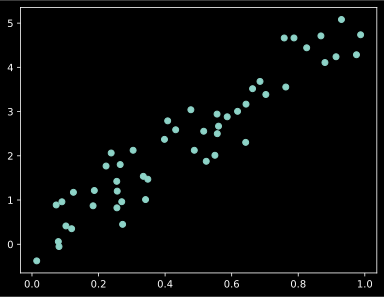

In [375]:
plt.scatter(x, y);

In [376]:
preds, losses = build_model(x, y)

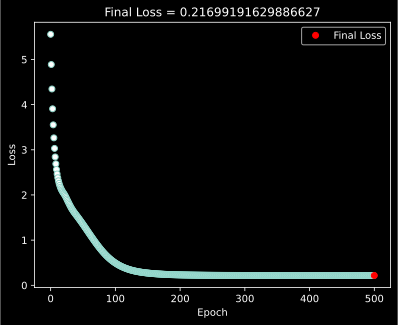

In [377]:
test_loss = (preds-y).pow(2).mean()

plt.plot(losses.detach(), "o", markerfacecolor="w", linewidth=1)
plt.plot(500, test_loss.detach(), "ro", label="Final Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend();
plt.title(f"Final Loss = {test_loss.item()}")
plt.show()

In [378]:
corr = np.corrcoef(gen[1].T, preds.detach().T)[0,1]


In [379]:
corr

0.06123417894040384

Fíjate, que la red neuronal sencilla que creamos, al aplicar una función no-lineal a la suma lineal ponderada inincial, no hace una "línea recta perfecta"

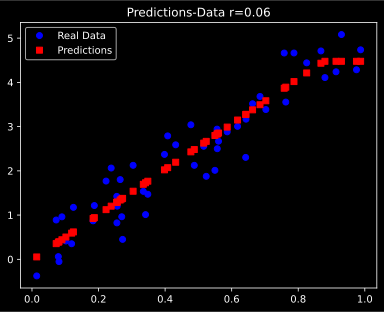

In [380]:
plt.plot(x,y, "bo", label="Real Data")
plt.plot(x, preds.detach(), "rs", label="Predictions")

plt.title(f"Predictions-Data r={corr:.2f}")
plt.legend();
plt.show();

_____________

El modelo puede caer en esta situación de datos aleatorios con pendiente variable desde -2 a 2 en 21 pasos en un mínimo local (dándonos una correlación entre datos predichos y reales de nan, básicamente 0). Por ello, al ser una situación aleatoria (y estar usando el GD Estocástico), ejecutamos cada combinación de pendiente, 50 veces

In [393]:
n_experiments = 50
slopes = torch.linspace(-2,2,21)

history = torch.zeros(len(slopes), 50, 2) 

for m_idx,slope in enumerate(slopes):
    
    for experiment in range(n_experiments):
    
    
        
        x,y = gen_data(m=slope)
        preds, losses = build_model(x,y)
        
        corr_coeff = np.corrcoef(y.T, preds.detach().T)[0,1]
        if np.isnan(corr_coeff): #para casos donde el modelo desempeñe totalmente mal (correlation=nan) lo sustituremos por un 0
            corr_coeff = 0
        
        history[m_idx][experiment][0] = losses[-1] #último valor de pérdida
        history[m_idx][experiment][1] = corr_coeff
        
#          = torch.tensor([losses.mean().item(),corr_coeff])
    
    
    if m_idx % 3 == 0:
        print(f"Sucessfully performed 50 experiments on a slope value of m={slope}")
        
        
        
        

C:\Users\pablo\miniconda3\envs\pytorch_workflow\Lib\site-packages\numpy\lib\function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
C:\Users\pablo\miniconda3\envs\pytorch_workflow\Lib\site-packages\numpy\lib\function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


Sucessfully performed 50 experiments on a slope value of m=-2.0
Sucessfully performed 50 experiments on a slope value of m=-1.399999976158142
Sucessfully performed 50 experiments on a slope value of m=-0.7999999523162842
Sucessfully performed 50 experiments on a slope value of m=-0.19999992847442627
Sucessfully performed 50 experiments on a slope value of m=0.3999999761581421
Sucessfully performed 50 experiments on a slope value of m=1.0
Sucessfully performed 50 experiments on a slope value of m=1.600000023841858


Tenemos un tensor de 50 filas donde cada una tiene 21 columnas (prueba con un valor de slope distinto), y dentro de cada prueba, 2 columnas donde se encuentra la pérdida promedio del modelo, y la correlación entre las predicciones y datos reales, entrenado durante 100 epochs para dicho set de datos aleatorio con dicha pendiente

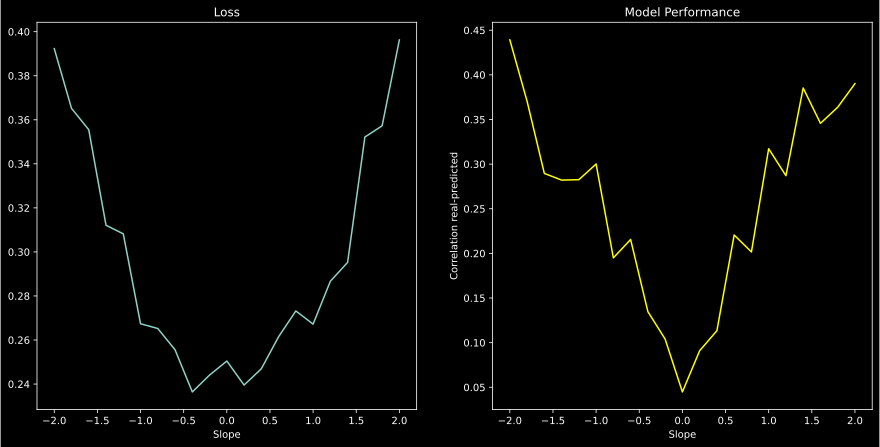

In [433]:
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(15,7), sharex=True);

axs[0].set_xlabel("Slope");
axs[0].set_title("Loss");
axs[0].plot(slopes, history[:,:,0].mean(dim=1).detach());


axs[1].set_title("Model Performance");
axs[1].plot(slopes, history[:,:,1].mean(dim=1).detach(), color="yellow")
axs[1].set_xlabel("Slope");
axs[1].set_ylabel("Correlation real-predicted");


> - #### Vemos que la pérdida va decreciendo en ambos lados de la pendiente (tanto negativa como positiva) y va siendo cada vez menor conforme se acerca a 0

> - #### En cambio, si visualizamos la correlación entre los valores reales y predichos, el modelo obtiene por ambos lados alto coeficiente de correlación (sobre todo con pendientes negativas) para estos datos aleatorios. Conforme la pendiente se acerca a 0 por ambos lados, va bajando el coeficiente hasta llegar a 0

- ### Parece contradictorio ver que, la pérdida es menor (lo que es preferible) cuando la pendiente de los datos aleatorios es 0, mientras que precisamente cuando la pendiente se aleja de 0, es cuando hay mayor correlación entre los datos reales y las predicciones

____________

### Por ejemplo, cuando la pérdida es alta, (pendiente=-2), el modelo tiene el coeficiente de correlación más alto. Veamos a qué se debe esto

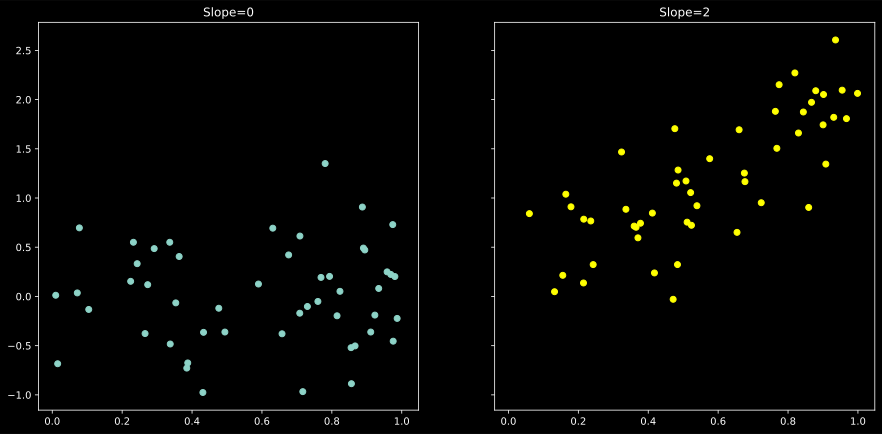

In [441]:
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(15,7), sharex=True, sharey=True);

x1,y1 = gen_data(m=0)
axs[0].set_title("Slope=0");
axs[0].scatter(x1, y1);


x2,y2 = gen_data(m=2)
axs[1].set_title("Slope=2");
axs[1].scatter(x2, y2, color="yellow");

### - Ambas gráficas están entre 0 y 1 en el eje x, y entre -1 y 3 en el eje y

### - El rango de valores que toma el eje y cuando la pendiente es 0 es mucho menor (están más cerca los datos) que cuando la pendiente es 2, (están más alejados)

- ### Por tanto, la varianza total en el eje `y` es mayor cuando la magnitud de la pendiente es mayor

- ### Debido a esta razón, cuando calculamos la pérdida, en el ejemplo anterior, usando MSE `(y-y_hat)**2`, los valores que tome dicha función de pérdida serán mayores ya que los valores están más distanciados entre sí.

> - ### Las pérdidas no están normalizadas, están en la escala de los datos. Mayor pendiente (slope) -> más varianza en `y`

> - ### **Por tanto, las pérdidas sólo pueden ser comparadas en los mismos sets de datos, en diferentes sets de datos, pero con la pérdida normalizada en el mismo rango numérico**

_______

> ## Pregunta: **Por qué el modelo "tuvo el peor desempeño" (correlación=0) cuando las pendientes de los sets aleatorios de datos se acercaban a 0?**

> ### `x` aporta menos información sobre y cuando la pendiente decrece. (El modelo tenía menos información útil sobre `y`). Cuanto mayor o más negativa (numéricamente) es la pendiente, más clara es la relación entre los datos, y por tanto mejor podrá establecer un patrón a dichos datos.

## **Las redes neuronales artificiales (y el DL en general) no aprenden valores de datos, sino la relación entre las variables (lo que puede ser complejo para humanos)**

_________